In [2]:
import re
import demoji
import random
import inflect
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, random_split

In [3]:
# Read the file with UTF-8 encoding
fil_path = 'human_chat.txt'
with open(fil_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

In [4]:
lines[:5]

['Human 1: Hi!\n',
 'Human 2: What is your favorite holiday?\n',
 'Human 1: one where I get to meet lots of different people.\n',
 'Human 2: What was the most number of people you have ever met during a holiday?\n',
 'Human 1: Hard to keep a count. Maybe 25.\n']

In [5]:
print(len(lines))

1495


## Preprocess Text 

In [6]:
def preprocess_text(text):
    # Remove HTML Tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    p = inflect.engine()
    demoji.download_codes()
    # Remove emojis
    text = demoji.replace(text, '')
    
    # Remove mention of human 1 and human 2
    text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)
    
    # Replace numbers with words
    text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)
    
    # Remove special characters, keeping only alphabetic and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Replace Specific unicode spaces with standard spaces and trim
    text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()
    return text

In [7]:
from tqdm.notebook import tqdm
preprocessed_text = [preprocess_text(line) for line in tqdm(lines)]

  0%|          | 0/1495 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_19912\1811098339.py:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
C:\Users\User\AppData\Local\Temp\ipykernel_19912\1811098339.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [8]:
preprocessed_text[:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

## Torchtext

Torch text is a library within the pytorch ecosystem desigend to facilitate the preprocssing of textual data 

**Get_tokenizer**
The **Get_tokenizer** function is one of the core utilites provided by torchtext for tokenizing text data.
**get_tokenizer** retrive a tokenizer function based on the mothod specified. This tokenizer can then be  used to convert strings of text into lists of tokens

**Parameter** 

Tokenizer: the argument specified the type of tokenizer to use. you can specified built-in tokenizers such as *basics_english* 'spacy',*moses* or even  provide a custome tokenizer function

**Langauge**: Some tokenizers, like those based on the moses or spacy libraries, might require you to specify the language of the text, which influences how the text is tokenized (e.g.. handing language specific puntuation and spliting rules)

In [9]:
tokenizer = get_tokenizer('basic_english')
tokenized_conv = [tokenizer(conv) for conv in preprocessed_text]

In [10]:
tokenized_conv[3]

['what',
 'was',
 'the',
 'most',
 'number',
 'of',
 'people',
 'you',
 'have',
 'ever',
 'met',
 'during',
 'a',
 'holiday']

## Build Vocab from Iterator

**build_vocab_from_iterator** : function in the torchtext.vocab module is used to create a vocabulary from an iterable of tokinzed data. This vocabularu is essential for converting textual data into numeraical form.

### Paramerters:

This is the main data input to the function. it should be an iterator(like a generator or a list) that yeilds sequences of tokens. Eac sequence represents a document or an example in your dataset

### Min Freq (int, optional):

This parameter specifies the minimum frequency a token must  have to be included in the vocabulary. Tokens that appears fewer min_freq times are exclude from the covabulary. This is useful removing rare words might be  typos or irrelevant to most analysis

### specials (list of str, optional):
 This is a list of special tokens that you want to add to the vocabulary. Common special tokens include:
'<pad>': A padding token used to equalize the lengths of sequences.
'<oov>' (or '<unk>' for "unknown"): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not in the training vocabulary.
### special_first (bool, optional):
 Determines the ordering of special tokens in the vocabulary. If True, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant (e.g., models using embedding layers might have specific handling for lower indices).

In [11]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1,
    specials=['<pad>', '<oov>'],
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1
)

In [12]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [13]:
print('Feature vocab Word: ', features_vocab_total_words)
print('Target Target Word: ', target_vocab_total_words)

Feature vocab Word:  2749
Target Target Word:  2747


## Making N-Grams from Conversion

In [14]:
def make_ngrams(tokenized_text):
    list_ngrams = []
    for i in range(1, len(tokenized_text)):
        ngram_sequence = tokenized_text[:i+1]
        list_ngrams.append(ngram_sequence)
        
    return list_ngrams

In [15]:
ngram_list = []
for tokenized_con in tqdm(tokenized_conv):
    ngram_list.extend(make_ngrams(tokenized_con))

  0%|          | 0/1495 [00:00<?, ?it/s]

In [16]:
ngram_list[:5]

[['what', 'is'],
 ['what', 'is', 'your'],
 ['what', 'is', 'your', 'favorite'],
 ['what', 'is', 'your', 'favorite', 'holiday'],
 ['one', 'where']]

**get_itos**: stands for 'index-to-string'. The method returns a list where the indices in the list correspoding to the numerical indeices used in in the model, and the values at those indices are actual stirng representation(tokens)

In [17]:
def text_to_numerical_sequence(tokenized_text):
    tokens_list = []
    if tokenized_text[-1] in target_vocab.get_itos():
        for token in tokenized_text[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

In [18]:
input_sequences = [text_to_numerical_sequence(sequence) for sequence in tqdm(ngram_list) if text_to_numerical_sequence(sequence)]

  0%|          | 0/18562 [00:00<?, ?it/s]

In [19]:
print(f"Total input Sequences: " ,{len(input_sequences)})
print(input_sequences[7:9])

Total input Sequences:  {18562}
[[56, 90, 2, 73, 2], [56, 90, 2, 73, 4, 228]]


In [20]:
x = [sequence[:-1] for sequence in input_sequences]
y = [sequence[-1] for sequence in input_sequences]
len(x[0]) , y[0]

(1, 11)

In [21]:
print((x[3], y[3]))

([12, 13, 29, 120], 312)


In [22]:
longest_squences_feature = max(len(sequence)  for sequence in x)
longest_squences_feature

153

`F.pad` function is a utility function which is part of torch.nn.functional module,used for padding tensors.

## Parameters 

**input(torch.tensor)**:
The tensor to be padded

**pad(tuple of ints)**:

The number of values padded to the edges of each dimension. The tuple should contain pairs where each pair is the values added to the left and right of the dimension, respectively.

**value(scaler, optinal)**:

The constant value used for constant padding. If the model is 'constant' but no value is specified. it defualt 
to 0.

In [23]:
padded_x = [F.pad(torch.tensor(sequence), (longest_squences_feature - len (sequence), 0), value= 0) for  sequence in x]
padded_x[1], x[2], len(padded_x[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 12, 13]),
 [12, 13, 29],
 153)

In [24]:
padded_x = torch.stack(padded_x)
y = torch.tensor(y)
type(y), type(padded_x)

(torch.Tensor, torch.Tensor)

In [25]:
y_one_hot = one_hot(y, num_classes=target_vocab_total_words)

## Tensor Dataset

**Tensor Dataset** : is a subclass of Dataset that is specifically designed to handle scenarios where all data are already in the form of  tensor. it warps tensor, allowing you to access slices of these tensors as individual samples.

It's particularly useful when yout entire datset is small enough to fit into memory, and you have pre-preprocess all your input and target data into tensor. it simplifies the data loading during training when using a Dataloader since all data is already in tensor form  and does not require further transformation or loading steps during the batch genration.

In [26]:
data = TensorDataset(padded_x, y_one_hot)

In [27]:
data

In [29]:
trian_size = int(0.8 * len(data))
test_size = len(data) - trian_size

batch_size = 32

In [31]:
train_data, test_data = random_split(data, [trian_size, test_size])

In [38]:
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [33]:
class My_BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [58]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
epochs = 100

In [48]:
model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

In [49]:
print(model)

My_BiLSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
model.to(device)

My_BiLSTM(
  (embedding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2747, bias=True)
)

In [53]:
def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [60]:
from tqdm import tqdm
import numpy as np

all_accuracies = []
all_losses = []

# Outer loop for epochs
for epoch in tqdm(range(epochs), desc="Epochs", position=0):
    model.train()
    epoch_losses = []
    
    # Inner loop for batches with a separate progress bar
    batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, position=1)
    for batch_X, batch_y in batch_pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
        
        # Store the loss for this batch
        epoch_losses.append(loss.item())
        
        # Calculate and display running average loss
        running_loss = np.mean(epoch_losses[-100:])  # average of last 100 batches
        batch_pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}", "Avg Loss": f"{running_loss:.4f}"})
    
    # Calculate average loss for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    all_losses.append(avg_epoch_loss)
    
    # Calculate accuracy
    accuracy = calculate_topk_accuracy(model, train_loader)
    all_accuracies.append(accuracy)
    
    # Update the epoch progress bar with the average loss and accuracy
    tqdm.write(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_epoch_loss:.4f} | Train K-Accuracy: {accuracy * 100:.2f}%")

# Final summary
print("\nTraining completed.")
print(f"Final Loss: {all_losses[-1]:.4f}")
print(f"Final Accuracy: {all_accuracies[-1]*100:.2f}%")

Epochs:   1%|          | 1/100 [00:12<20:11, 12.24s/it]

Epoch 1/100 | Avg Loss: 0.6262 | Train K-Accuracy: 96.36%


Epochs:   2%|▏         | 2/100 [00:23<18:54, 11.58s/it]

Epoch 2/100 | Avg Loss: 0.6132 | Train K-Accuracy: 96.35%


Epochs:   3%|▎         | 3/100 [00:34<18:05, 11.19s/it]

Epoch 3/100 | Avg Loss: 0.6004 | Train K-Accuracy: 96.34%


Epochs:   4%|▍         | 4/100 [00:44<17:38, 11.03s/it]

Epoch 4/100 | Avg Loss: 0.6160 | Train K-Accuracy: 96.30%


Epochs:   5%|▌         | 5/100 [00:55<17:23, 10.99s/it]

Epoch 5/100 | Avg Loss: 0.6073 | Train K-Accuracy: 96.33%


Epochs:   6%|▌         | 6/100 [01:06<17:04, 10.90s/it]

Epoch 6/100 | Avg Loss: 0.5949 | Train K-Accuracy: 96.38%


Epochs:   7%|▋         | 7/100 [01:17<16:48, 10.84s/it]

Epoch 7/100 | Avg Loss: 0.5858 | Train K-Accuracy: 96.34%


Epochs:   8%|▊         | 8/100 [01:27<16:27, 10.74s/it]

Epoch 8/100 | Avg Loss: 0.5901 | Train K-Accuracy: 96.39%


Epochs:   9%|▉         | 9/100 [01:38<16:16, 10.74s/it]

Epoch 9/100 | Avg Loss: 0.5812 | Train K-Accuracy: 96.28%


Epochs:  10%|█         | 10/100 [01:49<16:02, 10.70s/it]

Epoch 10/100 | Avg Loss: 0.5627 | Train K-Accuracy: 96.31%


Epochs:  11%|█         | 11/100 [02:00<16:10, 10.90s/it]

Epoch 11/100 | Avg Loss: 0.5678 | Train K-Accuracy: 96.38%


Epochs:  12%|█▏        | 12/100 [02:12<16:25, 11.20s/it]

Epoch 12/100 | Avg Loss: 0.5687 | Train K-Accuracy: 96.36%


Epochs:  13%|█▎        | 13/100 [02:24<16:31, 11.40s/it]

Epoch 13/100 | Avg Loss: 0.5634 | Train K-Accuracy: 96.36%


Epochs:  14%|█▍        | 14/100 [02:36<16:38, 11.61s/it]

Epoch 14/100 | Avg Loss: 0.5455 | Train K-Accuracy: 96.37%


Epochs:  15%|█▌        | 15/100 [02:48<16:33, 11.69s/it]

Epoch 15/100 | Avg Loss: 0.5368 | Train K-Accuracy: 96.37%


Epochs:  16%|█▌        | 16/100 [02:59<16:19, 11.66s/it]

Epoch 16/100 | Avg Loss: 0.5790 | Train K-Accuracy: 96.35%


Epochs:  17%|█▋        | 17/100 [03:11<16:05, 11.64s/it]

Epoch 17/100 | Avg Loss: 0.5583 | Train K-Accuracy: 96.38%


Epochs:  18%|█▊        | 18/100 [03:23<16:07, 11.80s/it]

Epoch 18/100 | Avg Loss: 0.5422 | Train K-Accuracy: 96.37%


Epochs:  19%|█▉        | 19/100 [03:35<15:52, 11.76s/it]

Epoch 19/100 | Avg Loss: 0.5345 | Train K-Accuracy: 96.36%


Epochs:  20%|██        | 20/100 [03:46<15:31, 11.64s/it]

Epoch 20/100 | Avg Loss: 0.5306 | Train K-Accuracy: 96.36%


Epochs:  21%|██        | 21/100 [03:58<15:19, 11.64s/it]

Epoch 21/100 | Avg Loss: 0.5204 | Train K-Accuracy: 96.35%


Epochs:  22%|██▏       | 22/100 [04:09<14:52, 11.44s/it]

Epoch 22/100 | Avg Loss: 0.5174 | Train K-Accuracy: 96.36%


Epochs:  23%|██▎       | 23/100 [04:20<14:32, 11.33s/it]

Epoch 23/100 | Avg Loss: 0.5087 | Train K-Accuracy: 96.36%


Epochs:  24%|██▍       | 24/100 [04:31<14:18, 11.30s/it]

Epoch 24/100 | Avg Loss: 0.4953 | Train K-Accuracy: 96.36%


Epochs:  25%|██▌       | 25/100 [04:42<14:07, 11.31s/it]

Epoch 25/100 | Avg Loss: 0.5037 | Train K-Accuracy: 96.36%


Epochs:  26%|██▌       | 26/100 [04:55<14:26, 11.70s/it]

Epoch 26/100 | Avg Loss: 0.5080 | Train K-Accuracy: 96.37%


Epochs:  27%|██▋       | 27/100 [05:08<14:51, 12.22s/it]

Epoch 27/100 | Avg Loss: 0.5057 | Train K-Accuracy: 96.38%


Epochs:  28%|██▊       | 28/100 [05:22<15:13, 12.69s/it]

Epoch 28/100 | Avg Loss: 0.4964 | Train K-Accuracy: 96.39%


Epochs:  29%|██▉       | 29/100 [05:36<15:31, 13.12s/it]

Epoch 29/100 | Avg Loss: 0.5013 | Train K-Accuracy: 96.37%


Epochs:  30%|███       | 30/100 [05:49<15:18, 13.12s/it]

Epoch 30/100 | Avg Loss: 0.5298 | Train K-Accuracy: 96.35%


Epochs:  31%|███       | 31/100 [06:03<15:09, 13.18s/it]

Epoch 31/100 | Avg Loss: 0.4974 | Train K-Accuracy: 96.40%


Epochs:  32%|███▏      | 32/100 [06:15<14:32, 12.84s/it]

Epoch 32/100 | Avg Loss: 0.4876 | Train K-Accuracy: 96.37%


Epochs:  33%|███▎      | 33/100 [06:27<14:03, 12.60s/it]

Epoch 33/100 | Avg Loss: 0.4860 | Train K-Accuracy: 96.33%


Epochs:  34%|███▍      | 34/100 [06:39<13:36, 12.37s/it]

Epoch 34/100 | Avg Loss: 0.5040 | Train K-Accuracy: 96.37%


Epochs:  35%|███▌      | 35/100 [06:50<13:09, 12.15s/it]

Epoch 35/100 | Avg Loss: 0.4850 | Train K-Accuracy: 96.37%


Epochs:  36%|███▌      | 36/100 [07:02<12:49, 12.03s/it]

Epoch 36/100 | Avg Loss: 0.4670 | Train K-Accuracy: 96.40%


Epochs:  37%|███▋      | 37/100 [07:14<12:36, 12.02s/it]

Epoch 37/100 | Avg Loss: 0.4767 | Train K-Accuracy: 96.37%


Epochs:  38%|███▊      | 38/100 [07:26<12:24, 12.00s/it]

Epoch 38/100 | Avg Loss: 0.4735 | Train K-Accuracy: 96.36%


Epochs:  39%|███▉      | 39/100 [07:38<12:18, 12.11s/it]

Epoch 39/100 | Avg Loss: 0.4708 | Train K-Accuracy: 96.38%


Epochs:  40%|████      | 40/100 [07:51<12:10, 12.17s/it]

Epoch 40/100 | Avg Loss: 0.4607 | Train K-Accuracy: 96.40%


Epochs:  41%|████      | 41/100 [08:03<12:07, 12.33s/it]

Epoch 41/100 | Avg Loss: 0.4667 | Train K-Accuracy: 96.40%


Epochs:  42%|████▏     | 42/100 [08:16<11:57, 12.37s/it]

Epoch 42/100 | Avg Loss: 0.4585 | Train K-Accuracy: 96.37%


Epochs:  43%|████▎     | 43/100 [08:28<11:51, 12.48s/it]

Epoch 43/100 | Avg Loss: 0.4630 | Train K-Accuracy: 96.41%


Epochs:  44%|████▍     | 44/100 [08:41<11:43, 12.56s/it]

Epoch 44/100 | Avg Loss: 0.4653 | Train K-Accuracy: 96.40%


Epochs:  45%|████▌     | 45/100 [08:54<11:27, 12.51s/it]

Epoch 45/100 | Avg Loss: 0.4492 | Train K-Accuracy: 96.38%


Epochs:  46%|████▌     | 46/100 [09:05<11:04, 12.31s/it]

Epoch 46/100 | Avg Loss: 0.4601 | Train K-Accuracy: 96.39%


Epochs:  47%|████▋     | 47/100 [09:16<10:30, 11.89s/it]

Epoch 47/100 | Avg Loss: 0.4649 | Train K-Accuracy: 96.41%


Epochs:  48%|████▊     | 48/100 [09:27<10:02, 11.58s/it]

Epoch 48/100 | Avg Loss: 0.4787 | Train K-Accuracy: 96.41%


Epochs:  49%|████▉     | 49/100 [09:39<09:47, 11.53s/it]

Epoch 49/100 | Avg Loss: 0.4569 | Train K-Accuracy: 96.40%


Epochs:  50%|█████     | 50/100 [09:50<09:35, 11.50s/it]

Epoch 50/100 | Avg Loss: 0.4564 | Train K-Accuracy: 96.39%


Epochs:  51%|█████     | 51/100 [10:02<09:25, 11.54s/it]

Epoch 51/100 | Avg Loss: 0.4462 | Train K-Accuracy: 96.42%


Epochs:  52%|█████▏    | 52/100 [10:13<09:12, 11.52s/it]

Epoch 52/100 | Avg Loss: 0.4515 | Train K-Accuracy: 96.42%


Epochs:  53%|█████▎    | 53/100 [10:24<08:54, 11.38s/it]

Epoch 53/100 | Avg Loss: 0.4550 | Train K-Accuracy: 96.40%


Epochs:  54%|█████▍    | 54/100 [10:35<08:37, 11.25s/it]

Epoch 54/100 | Avg Loss: 0.4543 | Train K-Accuracy: 96.38%


Epochs:  55%|█████▌    | 55/100 [10:47<08:27, 11.28s/it]

Epoch 55/100 | Avg Loss: 0.4342 | Train K-Accuracy: 96.39%


Epochs:  56%|█████▌    | 56/100 [10:58<08:23, 11.45s/it]

Epoch 56/100 | Avg Loss: 0.4455 | Train K-Accuracy: 96.40%


Epochs:  57%|█████▋    | 57/100 [11:10<08:14, 11.49s/it]

Epoch 57/100 | Avg Loss: 0.4526 | Train K-Accuracy: 96.40%


Epochs:  58%|█████▊    | 58/100 [11:21<08:03, 11.50s/it]

Epoch 58/100 | Avg Loss: 0.4388 | Train K-Accuracy: 96.42%


Epochs:  59%|█████▉    | 59/100 [11:33<07:50, 11.47s/it]

Epoch 59/100 | Avg Loss: 0.4351 | Train K-Accuracy: 96.41%


Epochs:  60%|██████    | 60/100 [11:44<07:38, 11.47s/it]

Epoch 60/100 | Avg Loss: 0.4436 | Train K-Accuracy: 96.40%


Epochs:  61%|██████    | 61/100 [11:56<07:24, 11.40s/it]

Epoch 61/100 | Avg Loss: 0.4350 | Train K-Accuracy: 96.40%


Epochs:  62%|██████▏   | 62/100 [12:06<07:07, 11.24s/it]

Epoch 62/100 | Avg Loss: 0.4324 | Train K-Accuracy: 96.38%


Epochs:  63%|██████▎   | 63/100 [12:18<06:59, 11.34s/it]

Epoch 63/100 | Avg Loss: 0.4341 | Train K-Accuracy: 96.37%


Epochs:  64%|██████▍   | 64/100 [12:30<06:54, 11.52s/it]

Epoch 64/100 | Avg Loss: 0.4387 | Train K-Accuracy: 96.41%


Epochs:  65%|██████▌   | 65/100 [12:42<06:46, 11.63s/it]

Epoch 65/100 | Avg Loss: 0.4338 | Train K-Accuracy: 96.38%


Epochs:  66%|██████▌   | 66/100 [12:54<06:36, 11.67s/it]

Epoch 66/100 | Avg Loss: 0.4184 | Train K-Accuracy: 96.40%


Epochs:  67%|██████▋   | 67/100 [13:05<06:20, 11.52s/it]

Epoch 67/100 | Avg Loss: 0.4180 | Train K-Accuracy: 96.38%


Epochs:  68%|██████▊   | 68/100 [13:16<06:06, 11.45s/it]

Epoch 68/100 | Avg Loss: 0.4214 | Train K-Accuracy: 96.42%


Epochs:  69%|██████▉   | 69/100 [13:33<06:45, 13.09s/it]

Epoch 69/100 | Avg Loss: 0.4208 | Train K-Accuracy: 96.42%


Epochs:  70%|███████   | 70/100 [13:49<07:03, 14.11s/it]

Epoch 70/100 | Avg Loss: 0.4122 | Train K-Accuracy: 96.38%


Epochs:  71%|███████   | 71/100 [14:12<08:02, 16.65s/it]

Epoch 71/100 | Avg Loss: 0.4209 | Train K-Accuracy: 96.41%


Epochs:  72%|███████▏  | 72/100 [14:28<07:36, 16.31s/it]

Epoch 72/100 | Avg Loss: 0.4174 | Train K-Accuracy: 96.38%


Epochs:  73%|███████▎  | 73/100 [14:44<07:21, 16.36s/it]

Epoch 73/100 | Avg Loss: 0.4300 | Train K-Accuracy: 96.38%


Epochs:  74%|███████▍  | 74/100 [15:00<07:04, 16.31s/it]

Epoch 74/100 | Avg Loss: 0.4229 | Train K-Accuracy: 96.40%


Epochs:  75%|███████▌  | 75/100 [15:17<06:48, 16.34s/it]

Epoch 75/100 | Avg Loss: 0.4319 | Train K-Accuracy: 96.40%


Epochs:  76%|███████▌  | 76/100 [15:34<06:36, 16.51s/it]

Epoch 76/100 | Avg Loss: 0.4298 | Train K-Accuracy: 96.40%


Epochs:  77%|███████▋  | 77/100 [15:51<06:25, 16.77s/it]

Epoch 77/100 | Avg Loss: 0.4219 | Train K-Accuracy: 96.42%


Epochs:  78%|███████▊  | 78/100 [16:07<06:04, 16.57s/it]

Epoch 78/100 | Avg Loss: 0.4173 | Train K-Accuracy: 96.42%


Epochs:  79%|███████▉  | 79/100 [16:24<05:49, 16.64s/it]

Epoch 79/100 | Avg Loss: 0.4066 | Train K-Accuracy: 96.41%


Epochs:  80%|████████  | 80/100 [16:41<05:33, 16.70s/it]

Epoch 80/100 | Avg Loss: 0.4113 | Train K-Accuracy: 96.40%


Epochs:  81%|████████  | 81/100 [16:57<05:12, 16.46s/it]

Epoch 81/100 | Avg Loss: 0.4174 | Train K-Accuracy: 96.40%


Epochs:  82%|████████▏ | 82/100 [17:13<04:55, 16.44s/it]

Epoch 82/100 | Avg Loss: 0.4056 | Train K-Accuracy: 96.42%


Epochs:  83%|████████▎ | 83/100 [17:29<04:38, 16.36s/it]

Epoch 83/100 | Avg Loss: 0.4109 | Train K-Accuracy: 96.39%


Epochs:  84%|████████▍ | 84/100 [17:45<04:20, 16.27s/it]

Epoch 84/100 | Avg Loss: 0.4063 | Train K-Accuracy: 96.42%


Epochs:  85%|████████▌ | 85/100 [18:01<04:01, 16.08s/it]

Epoch 85/100 | Avg Loss: 0.4053 | Train K-Accuracy: 96.42%


Epochs:  86%|████████▌ | 86/100 [18:17<03:44, 16.03s/it]

Epoch 86/100 | Avg Loss: 0.4079 | Train K-Accuracy: 96.43%


Epochs:  87%|████████▋ | 87/100 [18:33<03:29, 16.12s/it]

Epoch 87/100 | Avg Loss: 0.4199 | Train K-Accuracy: 96.41%


Epochs:  88%|████████▊ | 88/100 [18:50<03:15, 16.29s/it]

Epoch 88/100 | Avg Loss: 0.4374 | Train K-Accuracy: 96.40%


Epochs:  89%|████████▉ | 89/100 [19:05<02:57, 16.09s/it]

Epoch 89/100 | Avg Loss: 0.4159 | Train K-Accuracy: 96.41%


Epochs:  90%|█████████ | 90/100 [19:21<02:39, 15.99s/it]

Epoch 90/100 | Avg Loss: 0.4078 | Train K-Accuracy: 96.42%


Epochs:  91%|█████████ | 91/100 [19:36<02:21, 15.72s/it]

Epoch 91/100 | Avg Loss: 0.4118 | Train K-Accuracy: 96.42%


Epochs:  92%|█████████▏| 92/100 [19:52<02:06, 15.76s/it]

Epoch 92/100 | Avg Loss: 0.3917 | Train K-Accuracy: 96.41%


Epochs:  93%|█████████▎| 93/100 [20:09<01:51, 15.97s/it]

Epoch 93/100 | Avg Loss: 0.3908 | Train K-Accuracy: 96.42%


Epochs:  94%|█████████▍| 94/100 [20:24<01:35, 15.84s/it]

Epoch 94/100 | Avg Loss: 0.4070 | Train K-Accuracy: 96.41%


Epochs:  95%|█████████▌| 95/100 [20:40<01:18, 15.80s/it]

Epoch 95/100 | Avg Loss: 0.3900 | Train K-Accuracy: 96.42%


Epochs:  96%|█████████▌| 96/100 [20:55<01:02, 15.73s/it]

Epoch 96/100 | Avg Loss: 0.3946 | Train K-Accuracy: 96.41%


Epochs:  97%|█████████▋| 97/100 [21:11<00:46, 15.65s/it]

Epoch 97/100 | Avg Loss: 0.3950 | Train K-Accuracy: 96.40%


Epochs:  98%|█████████▊| 98/100 [21:27<00:31, 15.88s/it]

Epoch 98/100 | Avg Loss: 0.3994 | Train K-Accuracy: 96.41%


Epochs:  99%|█████████▉| 99/100 [21:43<00:15, 15.78s/it]

Epoch 99/100 | Avg Loss: 0.4076 | Train K-Accuracy: 96.40%


Epochs: 100%|██████████| 100/100 [21:59<00:00, 13.19s/it]

Epoch 100/100 | Avg Loss: 0.4036 | Train K-Accuracy: 96.40%

Training completed.
Final Loss: 0.4036
Final Accuracy: 96.40%


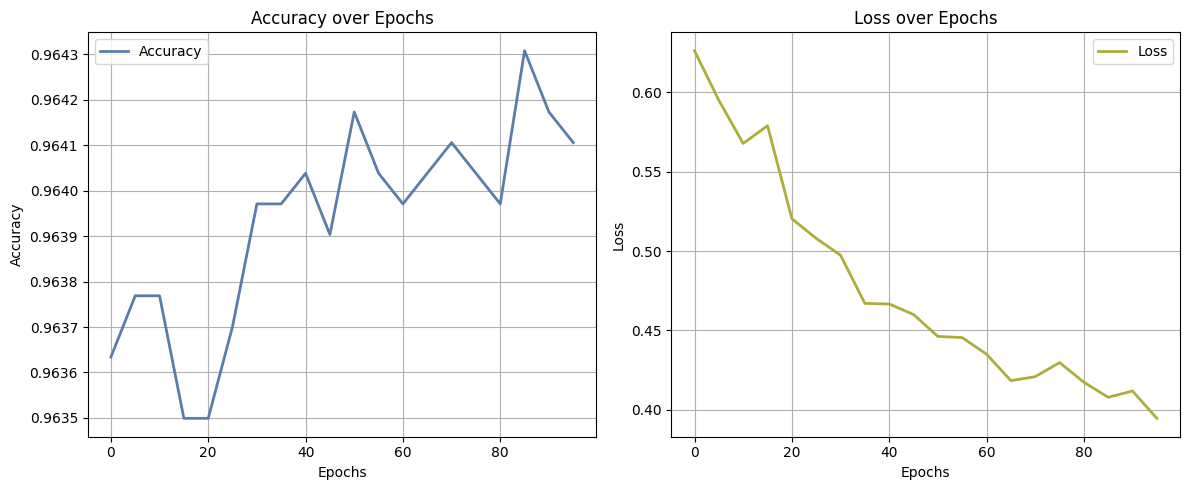

In [62]:
# Create epoch list for every 5th epoch
epoch_list = list(range(0, epochs, 5))

# Ensure all_accuracies and all_losses are sampled at the same intervals
sampled_accuracies = [all_accuracies[i] for i in range(0, len(all_accuracies), 5)]
sampled_losses = [all_losses[i] for i in range(0, len(all_losses), 5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(epoch_list, sampled_accuracies, color='#5a7da9', label='Accuracy', linewidth=2)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epoch_list, sampled_losses, color='#adad3b', label='Loss', linewidth=2)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss over Epochs')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [82]:
model_path = 'my_bilstm_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to my_bilstm_model.pth


In [83]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
saved_model = My_BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim)

In [84]:
model_path = 'my_bilstm_model.pth'
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [85]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

In [90]:
def use_model(input_list, top_k=5, additional_words=3):
    saved_model.eval()
    output_list = []
    for data in input_list:
        sentence = data[0]
        num_words = data[1]
        initial_predictions = []
        
        # Get initial predictions
        tokenized_input_test = tokenizer(sentence)
        tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
        padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                     (longest_squences_feature - len(tokenized_sequence_input_test) - 1, 0),
                                                     value=0)
        output_test_walking = saved_model(padded_tokenized_sequence_input_test.unsqueeze(0))
        top_predictions = torch.topk(output_test_walking, top_k)
        
        for index in top_predictions.indices.squeeze():
            predicted_word = target_vocab.lookup_token(index.item())
            initial_predictions.append(sentence + ' ' + predicted_word)
        
        # Extend each prediction
        for initial_pred in initial_predictions:
            current_sentence = initial_pred
            for _ in range(additional_words):
                tokenized_input_test = tokenizer(current_sentence)
                tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
                padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                             (longest_squences_feature - len(tokenized_sequence_input_test) - 1, 0),
                                                             value=0)
                output_test_walking = saved_model(padded_tokenized_sequence_input_test.unsqueeze(0))
                next_word_index = torch.argmax(output_test_walking).item()
                next_word = target_vocab.lookup_token(next_word_index)
                current_sentence += ' ' + next_word
                output_list.append(current_sentence)
    
    return output_list

In [91]:
input_test = [['This is', 1], ["How much", 1]]

In [92]:
outputs_model = use_model(input_test, 5)
outputs_model

['This is a very',
 'This is a very busy',
 'This is a very busy day',
 'This is it was',
 'This is it was a',
 'This is it was a really',
 'This is nice of',
 'This is nice of you',
 'This is nice of you for',
 'This is the first',
 'This is the first time',
 'This is the first time you',
 'This is your day',
 'This is your day going',
 'This is your day going to',
 'How much your day',
 'How much your day going',
 'How much your day going so',
 'How much you doing',
 'How much you doing busy',
 'How much you doing busy a',
 'How much a lot',
 'How much a lot of',
 'How much a lot of video',
 'How much the weather',
 'How much the weather will',
 'How much the weather will be',
 'How much it going',
 'How much it going to',
 'How much it going to try']